# Imports

In [1]:
import pandas as pd
import json
from datetime import datetime
import plotly.express as px
from pathlib import Path
import sys
from matplotlib.pyplot import ScalarFormatter
from asapdiscovery.data.readers.molfile import MolFileFactory
from harbor.analysis.cross_docking import DockingDataModel
import harbor.analysis.cross_docking as cd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
data = cd.DockingDataModel.deserialize("/Users/alexpayne/Scientific_Projects/mers-drug-discovery/sars2-retrospective-analysis/full_cross_dock_v2_combined_results/ALL_1_poses.parquet")

# Filter out all references that aren't the top 4 scaffolds

In [3]:
dfs = []
for i in [0,1,2,3]:
    dfs.append(data.dataframe[(data.dataframe['RefData_Scaffold_ID'].isin([i]))])

In [4]:
datamodels = [cd.DockingDataModel(dataframe=df, **data.model_dump()) for df in dfs]

In [5]:
# update default settings
default = cd.EvaluatorFactory(name="default")

default.success_rate_evaluator_settings.use = True
default.success_rate_evaluator_settings.success_rate_column = "PoseData_RMSD"

default.scorer_settings.rmsd_scorer_settings.use = True
default.scorer_settings.rmsd_scorer_settings.rmsd_column_name = "PoseData_RMSD"

default.scorer_settings.posit_scorer_settings.use = True
default.scorer_settings.posit_scorer_settings.posit_score_column_name = (
    "PoseData_docking-confidence-POSIT"
)

# basic date split cross docking
evf = default.__deepcopy__()
evf.name = "reference_split_comparison"
evf.reference_split_settings.use = True
evf.reference_split_settings.date_split_settings.use = True
evf.reference_split_settings.date_split_settings.reference_structure_date_column = (
    "RefData_Date"
)
evf.reference_split_settings.random_split_settings.use = True
evf.reference_split_settings.update_reference_settings.use = True
evf.reference_split_settings.update_reference_settings.use_logarithmic_scaling = (
    True
)

In [6]:
evs_list = [evf.create_evaluators(datamodel) for datamodel in datamodels]

In [7]:
len(evs_list)

4

In [8]:
print([len(evs) for evs in evs_list])

[28, 28, 28, 16]


# evaluate

In [9]:
results_list = []
for scaffold in [0, 1, 2, 3]:
    print(f"Evaluating scaffold {scaffold}")
    evs = evs_list[scaffold]
    datamodel = datamodels[scaffold]
    results = cd.Results.calculate_results(datamodel, evs)
    results_df = cd.Results.df_from_results(results)
    results_df["Scaffold_ID"] = scaffold
    results_list.append(results_df)

Evaluating scaffold 0


 75%|███████▌  | 21/28 [10:28<02:57, 25.39s/it]

Error processing bootstrap 1: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 2: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 3: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 4: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 5: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 6: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 7: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 8: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 9: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 10: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 11: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 12: Cannot sample 62 values from a list of 60 values.
Error processing bootstrap 13: Cannot

100%|██████████| 28/28 [15:09<00:00, 32.46s/it]

Error processing bootstrap 1: Number of Unique Structures (60) < N Structures to Return (62).Returning all unique structures.
Error processing bootstrap 2: Number of Unique Structures (60) < N Structures to Return (62).Returning all unique structures.
Error processing bootstrap 3: Number of Unique Structures (60) < N Structures to Return (62).Returning all unique structures.
Error processing bootstrap 4: Number of Unique Structures (60) < N Structures to Return (62).Returning all unique structures.
Error processing bootstrap 5: Number of Unique Structures (60) < N Structures to Return (62).Returning all unique structures.
Error processing bootstrap 6: Number of Unique Structures (60) < N Structures to Return (62).Returning all unique structures.
Error processing bootstrap 7: Number of Unique Structures (60) < N Structures to Return (62).Returning all unique structures.
Error processing bootstrap 8: Number of Unique Structures (60) < N Structures to Return (62).Returning all unique stru


100%|██████████| 28/28 [14:46<00:00, 31.66s/it]


Evaluating scaffold 2


100%|██████████| 28/28 [15:18<00:00, 32.81s/it]


Evaluating scaffold 3


100%|██████████| 16/16 [02:35<00:00,  9.73s/it]


In [11]:
combined_df = pd.concat(results_list, ignore_index=True)

In [12]:
combined_df.to_csv("top4_scaffolds_separate_references.csv", index=False)

# Plot

In [13]:
posit_results = Path("top4_scaffolds_separate_references.csv")
pdf = pd.read_csv(posit_results)
pdf["Error_Lower"] = pdf["Fraction"] - pdf["CI_Lower"]
pdf["Error_Lower"] = pdf["Error_Lower"].apply(lambda x: 0 if x < 0 else x)
pdf["Error_Upper"] = pdf["CI_Upper"] - pdf["Fraction"]
pdf["Error_Upper"] = pdf["Error_Upper"].apply(lambda x: 0 if x < 0 else x)

# Plotting

## Plot function

In [39]:
# Global configuration
fig_path = Path("./20250811_top4_scaffolds_separate_references")
fig_path.mkdir(parents=True, exist_ok=True)

FIGNUM_GLOBAL = 0

# def save_fig(fig, filename, dpi=200, suffix=".pdf"):
#     """Save the figure with a global figure number."""
#     global FIGNUM_GLOBAL
#     FIGNUM_GLOBAL += 1
#     figpath = Path(fig_path / f"{filename}_{FIGNUM_GLOBAL:02d}")
#     fig.savefig(figpath.with_suffix(suffix), 
#                 bbox_inches="tight", 
#                 dpi=dpi)

def save_fig(fig, filename, dpi=200, suffix=".pdf"):
    figpath = Path(fig_path / f"{filename}")
    fig.savefig(figpath.with_suffix(suffix), 
                bbox_inches="tight", 
                dpi=dpi)
    

sns.set_style("white")
label_map = {
    "Reference_Split": "Dataset Split Type",
    "Score": "Scoring Method",
    "RandomSplit": "Randomly Ordered",
    "DateSplit": "Ordered by Date",
    "RMSD": "RMSD (Positive Control)",
    "POSIT_Probability": "POSIT Probability",
    "ScaffoldDateSplit": "One Structure Per Scaffold",
    # "N_Reference_Structures": "Number of Randomly Chosen Reference Structures",
    "N_Reference_Structures": "Number of Reference Structures Available to Use \n(Log Scale)",
    "Fraction": "Fraction of Ligands Posed \n<2Å from Reference",
    "CI_Lower": "Confidence Interval Lower Bound",
    "CI_Upper": "Confidence Interval Upper Bound",
    "N_Refs_Per_Scaffold": "# Reference Structures Per Scaffold",
    "Query_Scaffold": "Query Scaffold ID",
    "Scaffold_ID": "Scaffold ID",
}
for column in pdf.columns:
    if not column in label_map:
        label_map[column] = column
        
X_VAR = label_map["N_Reference_Structures"]
Y_VAR = label_map["Fraction"]
X_LABEL = label_map["N_Reference_Structures"]
Y_LABEL = label_map["Fraction"]
# QUERY_SCAFFOLD_ID = label_map["Query_Scaffold_ID_Subset_1"]
# REF_SCAFFOLD_ID = label_map["Reference_Scaffold_ID_Subset_1"]
COLOR_VAR = label_map["Reference_Split"]
STYLE_VAR = label_map["Score"]
CI_LOWER = label_map["CI_Lower"]
CI_UPPER = label_map["CI_Upper"]
LARGE_FIG_SIZE = (12, 8)
SMALL_FIG_SIZE = (8, 6)
FONT_SIZES = {
    "xlabel": 24,
    "ylabel": 24,
    "ticks": 18,
    "legend_title": 24,
    "legend_text": 18,
}
ALPHA = 0.1
n_refs = sorted(pdf["N_Reference_Structures"].unique())

In [51]:
def plot_filled_in_error_bars(
    raw_df,
    x_var=X_VAR,
    y_var=Y_VAR,
    color_var=COLOR_VAR,
    style_var=STYLE_VAR,
    ci_lower=CI_LOWER,
    ci_upper=CI_UPPER,
    reverse_hue_order=False,
    reverse_style_order=False,
    n_refs= n_refs,
    fill_between=True,
    log_scale=True,
    add_default_line=False,
    y_ticks=(0.0, 0.2, 0.4, 0.6, 0.8, 1.0),
):
    # Sort the dataframe
    raw_df = raw_df.sort_values(by=[x_var, style_var, color_var])
    plt.figure(figsize=(LARGE_FIG_SIZE[0], LARGE_FIG_SIZE[1]))
    
    # Define hue and style orders
    hue_order = list(reversed(sorted(raw_df[color_var].unique()))) if reverse_hue_order else list(sorted(raw_df[color_var].unique()))
    style_order = list(reversed(sorted(raw_df[style_var].unique()))) if reverse_style_order else list(sorted(raw_df[style_var].unique()))
    
    # Create color mapping
    unique_colors = sns.color_palette(n_colors=len(raw_df[color_var].unique()))
    color_map = dict(zip(hue_order, unique_colors))
    
    
    
    # Create the line plot
    fig = sns.lineplot(
        data=raw_df,
        x=x_var,
        y=y_var,
        hue=color_var,
        style=style_var,  # Keep style_var for line styles
        palette=color_map,
        hue_order=hue_order,
        style_order= style_order,
    )
    
    if add_default_line:
        # add black line for pdsr RMSD DateSplit
        sns.lineplot(pdsr, x=X_VAR, y=Y_VAR, color="black", linestyle="--", label=None)

    if fill_between:
        # Create fill between for each group using matched colors
        for name, group in raw_df.groupby([color_var, style_var]):
            color_name = name[0]  # First element is Score
            fig.fill_between(
                group[x_var],
                group[ci_lower],
                group[ci_upper],
                color=color_map[color_name],
                alpha=ALPHA,
            )
    
    # Customize each subplot
    if log_scale:
        fig.set_xscale("log")
        fig.xaxis.set_major_formatter(ScalarFormatter())

    custom_ticks = n_refs
    fig.set_xticks(custom_ticks)
    fig.set_xticklabels(custom_ticks, fontsize=FONT_SIZES["ticks"])
    fig.tick_params(axis='y', labelsize=FONT_SIZES["ticks"])
    
    fig.set_yticks(y_ticks)
    fig.set_yticklabels(y_ticks, fontsize=FONT_SIZES["ticks"])

    fig.set_xlabel(X_LABEL, fontsize=FONT_SIZES["xlabel"], fontweight="bold")
    fig.set_ylabel(Y_LABEL, fontsize=FONT_SIZES["ylabel"], fontweight="bold")

    # Customize legend
    legend = fig.legend()
    plt.setp(legend.get_title(), fontsize=FONT_SIZES["legend_title"], fontweight="bold")
    plt.setp(legend.get_texts(), fontsize=FONT_SIZES["legend_text"])
    return plt

## update labels

In [52]:
pdsr = pd.read_csv("/Users/alexpayne/Scientific_Projects/mers-drug-discovery/sars2-retrospective-analysis/full_cross_dock_v2_analyzed_results/ALL_1_poses_datesplit_combined_results.csv")

In [53]:
pdsr["Error_Lower"] = pdsr["Fraction"] - pdsr["CI_Lower"]
pdsr["Error_Lower"] = pdsr["Error_Lower"].apply(lambda x: 0 if x < 0 else x)
pdsr["Error_Upper"] = pdsr["CI_Upper"] - pdsr["Fraction"]
pdsr["Error_Upper"] = pdsr["Error_Upper"].apply(lambda x: 0 if x < 0 else x)

In [54]:
pdsr = pdsr.rename(columns=label_map)
for column in pdsr.columns:
    pdsr[column] = pdsr[column].apply(lambda x: label_map.get(x,x))

In [55]:
pdsr = pdsr[(pdsr[label_map["Score"]] == label_map["POSIT_Probability"]) & (pdsr[label_map["Reference_Split"]] == label_map["DateSplit"])]

In [56]:
df = pdf.copy()
df = df.rename(columns=label_map)
for column in df.columns:
    df[column] = df[column].apply(lambda x: label_map.get(x, x))
df.columns
df[label_map["Scaffold_ID"]] = df[label_map["Scaffold_ID"]].apply(lambda x: int(x) + 1)

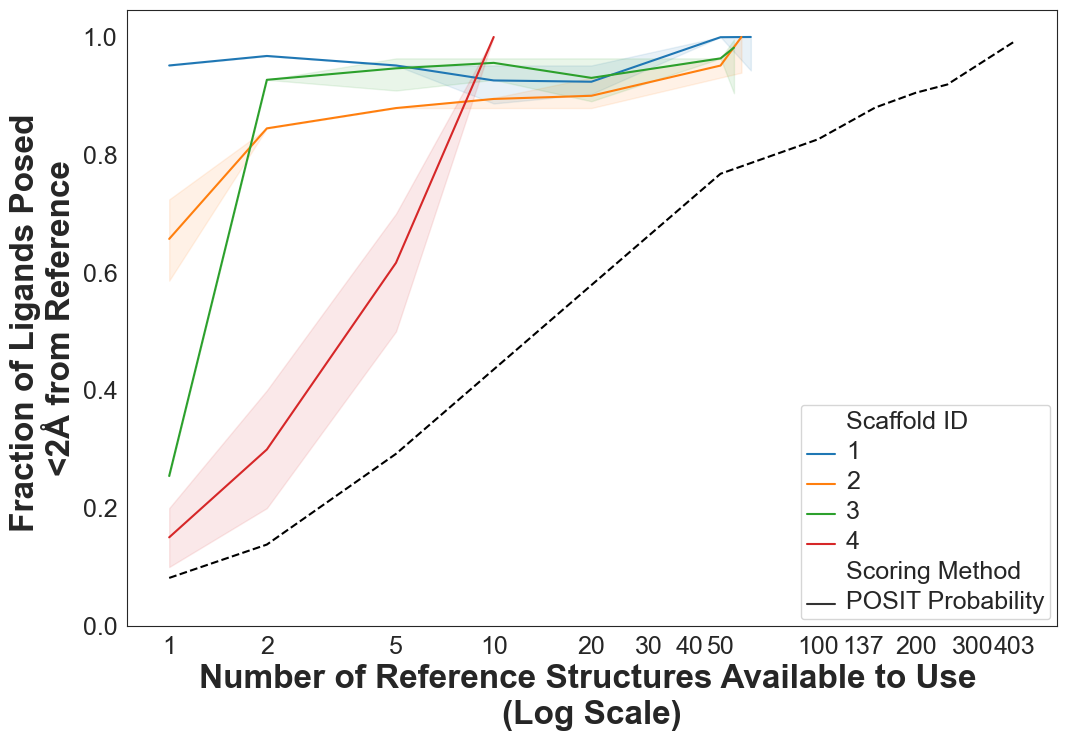

In [60]:
plot_df = df[(df[label_map["Score"]] == label_map["POSIT_Probability"]) & 
             (df[label_map["Reference_Split"]] == label_map["DateSplit"])]
fig = plot_filled_in_error_bars(plot_df, 
                                x_var=label_map["N_Reference_Structures"],
                                fill_between=True,
                                color_var=label_map["Scaffold_ID"],
                                n_refs= [1, 2, 5, 10, 20, 30, 40, 50, 100, 137, 200, 300, 403],
                                add_default_line=True)
save_fig(fig, "top4_scaffolds_self_docked_datesplit_posit_probability")

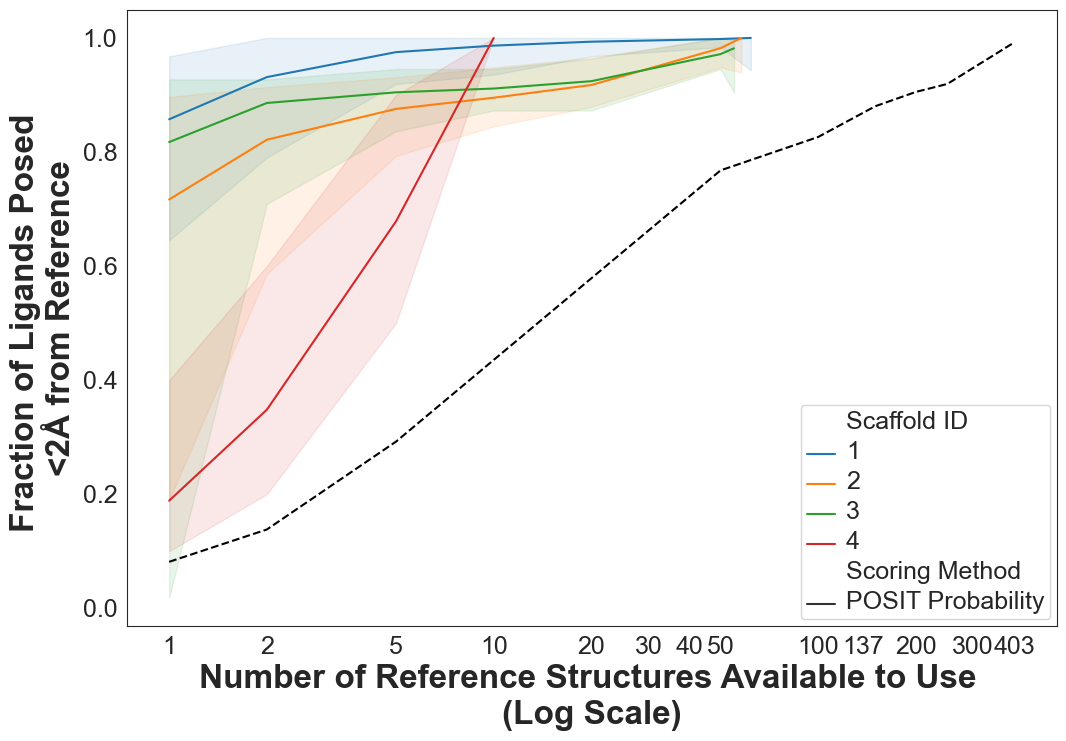

In [61]:
plot_df = df[(df[label_map["Score"]] == label_map["POSIT_Probability"]) & 
             (df[label_map["Reference_Split"]] == label_map["RandomSplit"])]
fig = plot_filled_in_error_bars(plot_df, 
                                x_var=label_map["N_Reference_Structures"],
                                fill_between=True,
                                color_var=label_map["Scaffold_ID"],
                                n_refs= [1, 2, 5, 10, 20, 30, 40, 50, 100, 137, 200, 300, 403],
                                add_default_line=True)
save_fig(fig, "top4_scaffolds_self_docked_randomsplit_posit_probability")

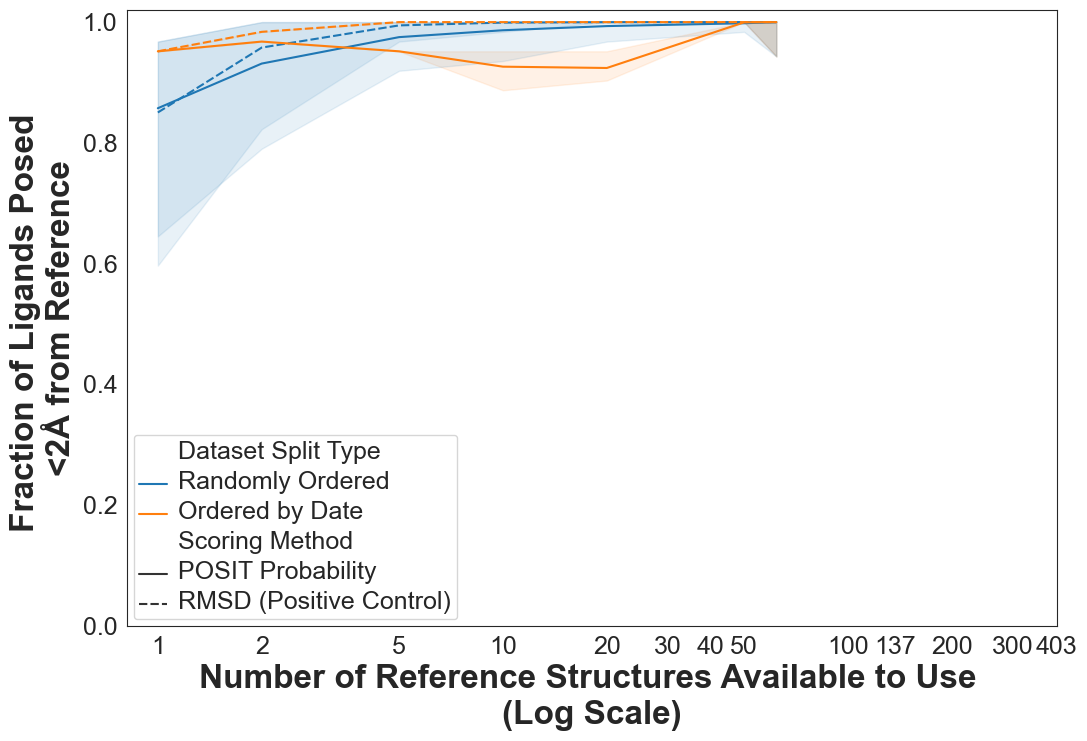

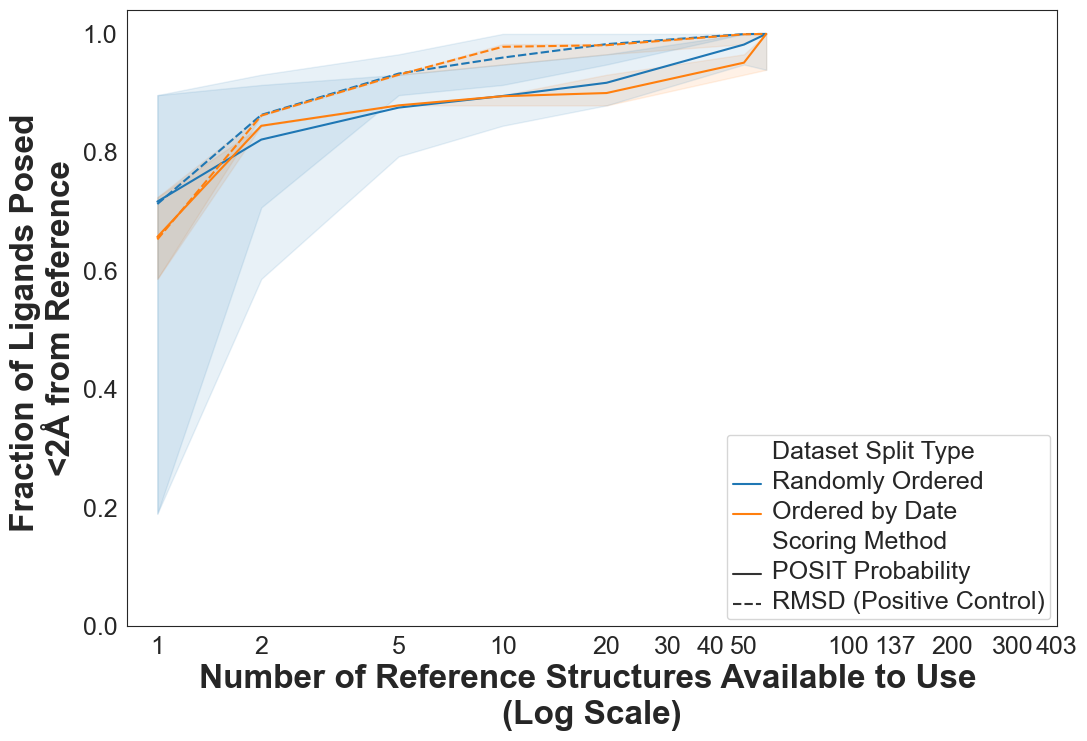

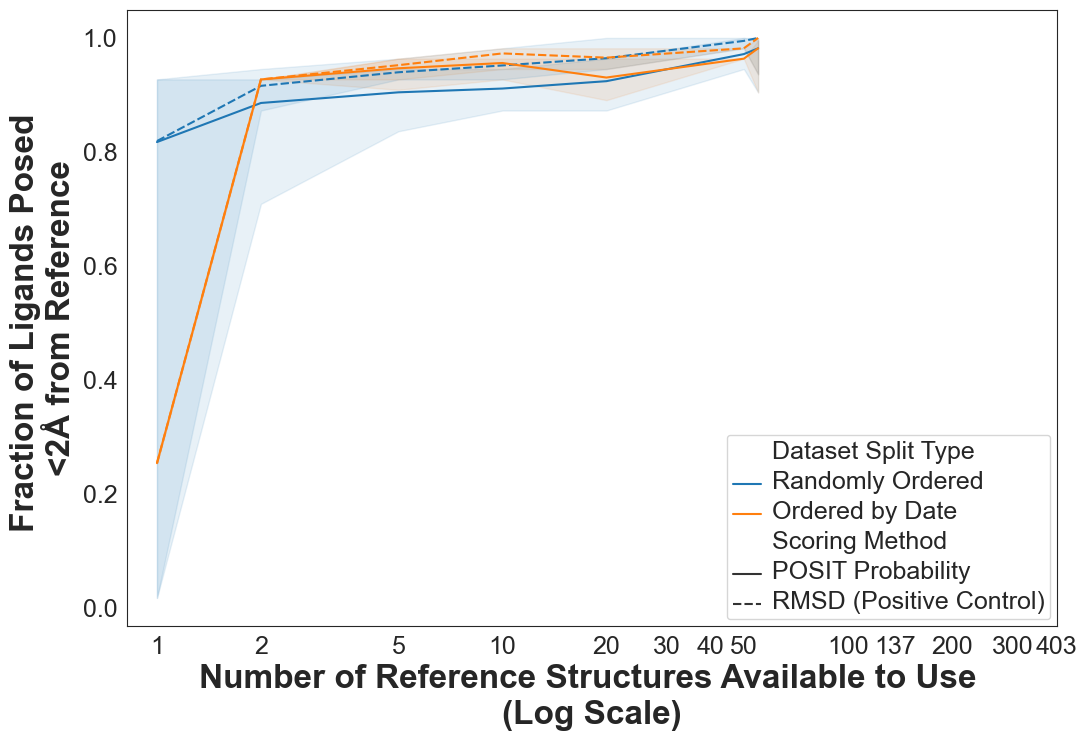

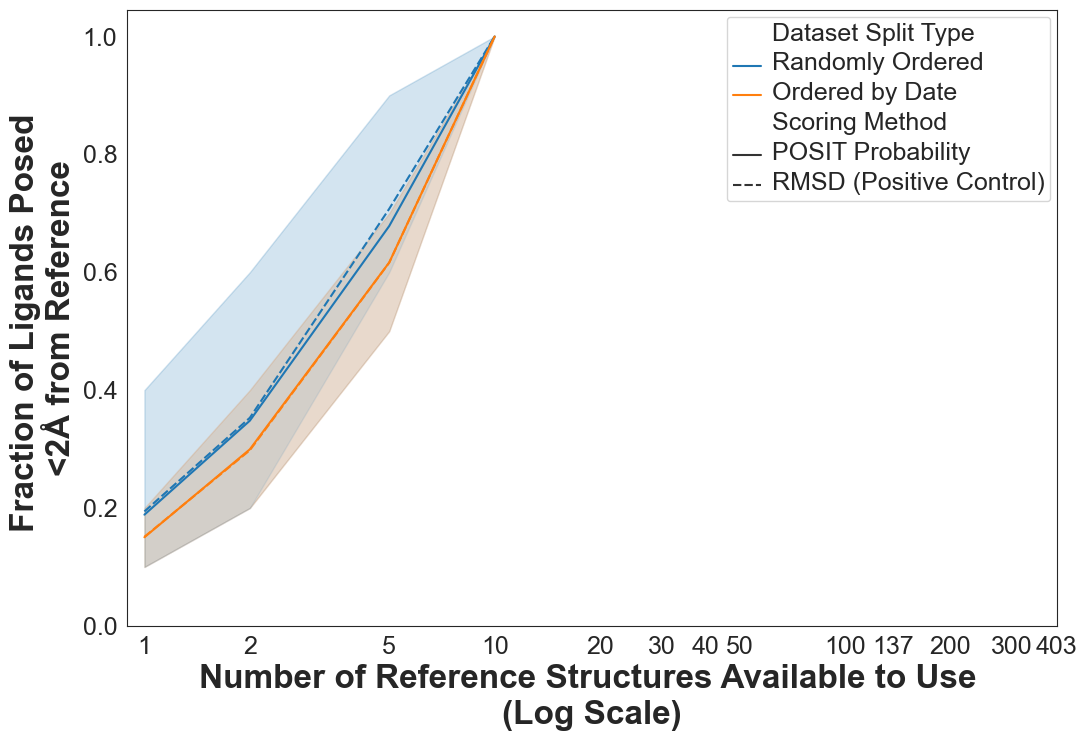

In [59]:
for s in [1,2,3,4]:
    plot_df = df[df[label_map["Scaffold_ID"]] == s]
    plot_df.sort_values([label_map["Reference_Split"], label_map["Score"], label_map["N_Reference_Structures"]])
    fig = plot_filled_in_error_bars(plot_df, 
                                    x_var=label_map["N_Reference_Structures"], color_var=label_map["Reference_Split"], 
                                    reverse_hue_order=True,
                                    n_refs=[1, 2, 5, 10, 20, 30, 40, 50, 100, 137, 200, 300, 403])
    save_fig(fig, f"date_split_by_scaffold_{s}")